# Two-Pipette Calibration - Moving Uncalibrated Pipette into Calibrated One
Use this notebook for the two-pipette calibration procedure, if you pushed the uncalibrated pipette into a stationary calibrated one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib import rc
plt.style.use('default')
rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':16})
rc('text', usetex=False)
rc('axes', titlesize=18, labelsize=20)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

Start by importing the data and plotting the position of the uncalibrated pipette vs time. Change the fit ranges around until Range I defines the pipette motion prior to contact, and Range II is the time over which the pipettes are in contact and increasingly deflecting one another.

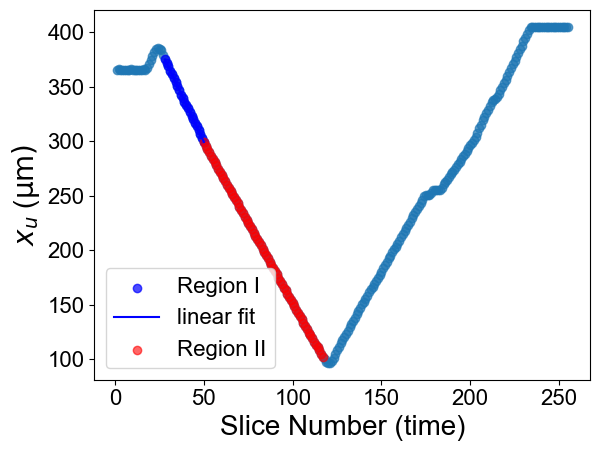

In [55]:
# Import data
k_c = 0.090884 # uN/um
experiment_folder = 'pip 7 new bent cal raw 23.04/pip7_cal6/'
calpip_filename = 'calibrated_pipette_um_scaled.csv' # calibrated pipette center of mass motion
newpip_filename = 'uncalibrated_pipette_um_scaled.csv'

calpip_df = pd.read_csv(experiment_folder+calpip_filename)
newpip_df = pd.read_csv(experiment_folder+newpip_filename)

slice = np.array(newpip_df['Slice'])
newpip_ym = np.array(newpip_df['YM']) # center of mass position of the tip

# Define the two regimes for pipette displacement data (pre- and post-contact).
ft_range1 = (28, 50) # this range should end at the moment the slope changes, when contact occurs
fm_range2 = (50, 117) # this range should end on the slice number just before the deflection stops increasing

data_range1 = newpip_df[(newpip_df['Slice'] >= ft_range1[0]) & (newpip_df['Slice'] <= ft_range1[1])]
data_range2 = newpip_df[(newpip_df['Slice'] >= fm_range2[0]) & (newpip_df['Slice'] <= fm_range2[1])]
calpip_range2 = calpip_df[(calpip_df['Slice'] >= fm_range2[0]) & (calpip_df['Slice'] <= fm_range2[1])] # new pipette data in Region II

# Make linear regression model for data in region 1
lm2 = stats.linregress(data_range1['Slice'], data_range1['YM'])

# Plot the data for region 2 in red and the linear regression for region 1 in blue
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(slice, newpip_ym, alpha=0.7)
ax1.scatter(data_range1['Slice'], data_range1['YM'], color='blue', alpha=0.7, label='Region I')
ax1.plot(data_range1['Slice'], lm2.intercept + lm2.slope * data_range1['Slice'], color='blue', label='linear fit')
ax1.scatter(data_range2['Slice'], data_range2['YM'], alpha=0.6, color='red', label='Region II')
ax1.set_xlabel('Slice Number (time)')
ax1.set_ylabel(r'$x_u$ ($\mathrm{{\mu m}})$')
ax1.legend()

Next, calculate the deflection of the uncalibrated pipette from its equilibrium position. Using the data for the calibrated pipette in region II, calculate the force that pipette exerts on the uncalibrated pipette. Then plot $F_c$ against $\Delta x_u$.

max deflection is 374.734054486 um, max force is 34.057329807905624 uN.


<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jpopows\AppData\Local\Temp\ipykernel_23096\1988457594.py:26: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(deltax_pip, lm3.intercept + lm3.slope * deltax_pip, label=f'$k={np.abs(lm3.slope):.4f} \pm {ts*lm3.stderr:.4f} \mathrm{{\mu N/\mu m}}$')
C:\Users\jpopows\AppData\Local\Temp\ipykernel_23096\1988457594.py:26: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(deltax_pip, lm3.intercept + lm3.slope * deltax_pip, label=f'$k={np.abs(lm3.slope):.4f} \pm {ts*lm3.stderr:.4f} \mathrm{{\mu N/\mu m}}$')
C:\Users\jpopows\AppData\Local\Temp\ipykernel_23096\1988457594.py:26: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(deltax_pip, lm3.intercept + lm3.slope * delta

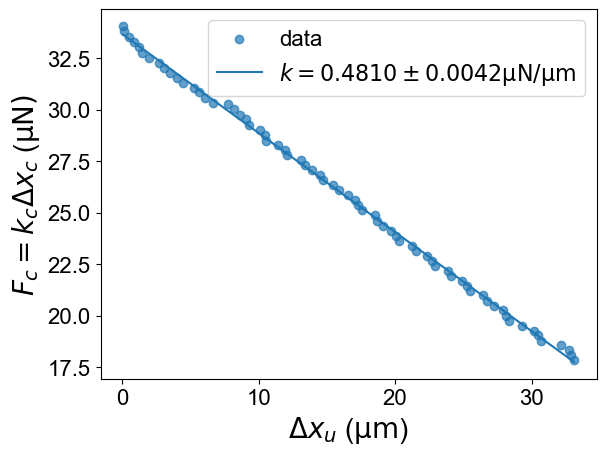

Pipette spring constant (and 95% confidence interval): 0.481023 +/- 0.004215 uN/um


In [56]:
# Project linear fit of Region I into Region II
projected_lm2_vals = lm2.intercept + lm2.slope * data_range2['Slice']
measured_vals = data_range2['YM']

# Actual uncalibrated pipette deflection is absolute value of the difference between projected_lm1 and lm2 values
deltax_pip = np.abs(projected_lm2_vals - measured_vals) # um

# Get the calibrated pipette's deflection
calpip_ym = calpip_range2['YM']

# Calculate the force exerted by the calibrated pipette
F_c = k_c*calpip_ym # uN
print('max deflection is', np.max(calpip_ym), 'um, max force is', np.max(F_c), 'uN.')

# Make linear regression model between F_c and deltax_pip
lm3 = stats.linregress(deltax_pip, F_c)

# Calculate 95% confidence interval on the fitted slope for error value
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df)) # Two-sided inverse Students t-distribution. Here p=probability, df=degrees of freedom
ts = tinv(0.05, len(deltax_pip)-2)

# Plot F_c vs the uncalibrated deflection, alongside the linear regression model
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(deltax_pip, F_c, alpha=0.7, label = 'data')
ax1.plot(deltax_pip, lm3.intercept + lm3.slope * deltax_pip, label=f'$k={np.abs(lm3.slope):.4f} \pm {ts*lm3.stderr:.4f} \mathrm{{\mu N/\mu m}}$')
ax1.set_xlabel(r'$\Delta x_{u}$ ($\mathrm{{\mu m}}$)')
ax1.set_ylabel(r'$F_c=k_c \Delta x_c$ ($\mathrm{{\mu N}})$')
ax1.legend()
#plt.savefig(experiment_folder+'pip_calibration_figure.pdf')
plt.show()

print(f"Pipette spring constant (and 95% confidence interval): {np.abs(lm3.slope):.6f} +/- {ts*lm3.stderr:.6f} uN/um")

For reference, this is what the force exerted by the calibrated pipette versus time plot looks like.

Text(0, 0.5, '$F_c=k_c \\Delta x_c$ ($\\mathrm{{\\mu N}})$')

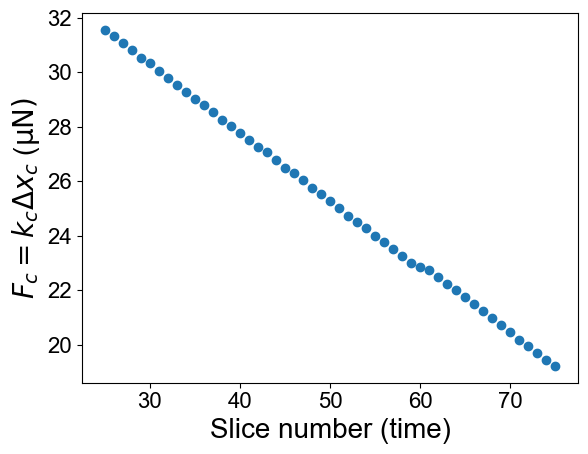

In [41]:
deflect_slices = calpip_range2['Slice']
plt.scatter(deflect_slices, F_c)
plt.xlabel('Slice number (time)')
plt.ylabel(r'$F_c=k_c \Delta x_c$ ($\mathrm{{\mu N}})$')